In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as mpatches
from pyfonts import load_google_font
from highlight_text import fig_text
from drawarrow import ax_arrow
import matplotlib.patheffects as path_effects
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
attribution_studies = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-08-12/attribution_studies.csv")

In [3]:
attribution_studies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event_name         744 non-null    object 
 1   event_period       735 non-null    object 
 2   event_year         592 non-null    object 
 3   study_focus        744 non-null    object 
 4   iso_country_code   520 non-null    object 
 5   cb_region          744 non-null    object 
 6   event_type         744 non-null    object 
 7   classification     744 non-null    object 
 8   summary_statement  744 non-null    object 
 9   publication_year   743 non-null    float64
 10  citation           743 non-null    object 
 11  source             744 non-null    object 
 12  rapid_study        744 non-null    object 
 13  link               744 non-null    object 
dtypes: float64(1), object(13)
memory usage: 81.5+ KB


In [4]:
attribution_studies.head(2)

,event_name,event_period,event_year,study_focus,iso_country_code,cb_region,event_type,classification,summary_statement,publication_year,citation,source,rapid_study,link
0,European summer heatwave,2003,2003,Event,NaN,Europe,Heat,More severe or more likely to occur,"""We estimate it is very likely (confidence lev...",2004.0,"Stott, P. et al., 2004: Human contribution to ...",Nature,No,https://www.nature.com/nature/journal/v432/n70...
1,Global temperature extremes,since 1950,NaN,Trend,NaN,Global,Heat,More severe or more likely to occur,"""Comparing these observations with climate mod...",2005.0,"Christidis, N. et al., 2005: Detection of chan...",Geophysical Research Letters,No,https://agupubs.onlinelibrary.wiley.com/doi/fu...


# Data preparation

In [5]:
# Regions to filter for Africa where iso country code is available
regions = ["Sub-Saharan Africa", "Northern Africa and western Asia"]
africa = attribution_studies[attribution_studies["cb_region"].isin(regions)].copy().dropna(subset=["iso_country_code"])

In [6]:
africa.head(2)

,event_name,event_period,event_year,study_focus,iso_country_code,cb_region,event_type,classification,summary_statement,publication_year,citation,source,rapid_study,link
37,Congo Basin dry season low rainfall extremes,1960s-2000s,NaN,Trend,COD,Sub-Saharan Africa,Drought,No discernible human influence,"""There are no significant changes in the risk ...",2013.0,"Otto, F. E. L. et al. 2013: Attribution of cha...",Philosophical Transactions of the Royal Society B,No,https://royalsocietypublishing.org/doi/10.1098...
38,Eastern Kenya & southern Somalia rainfall defi...,2012,2012,Event,"KEN,SOM",Sub-Saharan Africa,Drought,Insufficient data/inconclusive,"""The results indicate that non-ENSO SST variat...",2013.0,"Funk, C. et al., 2013: Attribution of 2012 and...",Bulletin of the American Meteorological Society,No,http://journals.ametsoc.org/doi/pdf/10.1175/BA...


In [7]:
# Split iso country code into separate columns and reshape the data from wide to long format
df_expanded = africa.set_index(["cb_region", "event_type", "classification"])["iso_country_code"].str.split(",", expand=True).stack().reset_index(name="iso_country_code")
df_expanded = df_expanded[["iso_country_code", "event_type", "classification"]]
df_expanded

,iso_country_code,event_type,classification
0,COD,Drought,No discernible human influence
1,KEN,Drought,Insufficient data/inconclusive
2,SOM,Drought,Insufficient data/inconclusive
3,BWA,Rain & flooding,"Decrease, less severe or less likely to occur"
4,AGO,Rain & flooding,"Decrease, less severe or less likely to occur"
...,...,...,...
74,KEN,Rain & flooding,More severe or more likely to occur
75,UGA,Rain & flooding,More severe or more likely to occur
76,TZA,Rain & flooding,More severe or more likely to occur
77,ARE,Rain & flooding,Insufficient data/inconclusive


In [8]:
# Count ison country code for each group
df_grouped = df_expanded.groupby(["classification", "event_type", "iso_country_code"])["iso_country_code"].value_counts().reset_index()
# Check the range of count values to create height bins for the spikes
df_grouped["count"].describe()

count    66.00000
mean      1.19697
std       0.66146
min       1.00000
25%       1.00000
50%       1.00000
75%       1.00000
max       5.00000
Name: count, dtype: float64

In [9]:
# Assign count values to height
bins = [0, 1, 2, 3, 4, 6]  
labels = [2, 4, 6, 8, 10]
df_grouped['height'] = pd.cut(df_grouped["count"], bins=bins, labels=labels)
df_grouped

,classification,event_type,iso_country_code,count,height
0,"Decrease, less severe or less likely to occur",Impact,ZAF,1,2
1,"Decrease, less severe or less likely to occur",Rain & flooding,AGO,1,2
2,"Decrease, less severe or less likely to occur",Rain & flooding,BFA,1,2
3,"Decrease, less severe or less likely to occur",Rain & flooding,BWA,1,2
4,"Decrease, less severe or less likely to occur",Rain & flooding,MLI,1,2
...,...,...,...,...,...
61,No discernible human influence,Rain & flooding,BFA,1,2
62,No discernible human influence,Rain & flooding,BWA,1,2
63,No discernible human influence,Rain & flooding,KEN,3,6
64,No discernible human influence,Rain & flooding,MLI,1,2


In [10]:
# Load world geojson and filter for Africa
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/world/world.geojson"
world = gpd.read_file(url)
world = world[world["continent"] == "Africa"]

In [11]:
# Merge df with africa 
df_merged = world.merge(
  df_grouped,  
  left_on="code_adm",
  right_on="iso_country_code",
)

In [12]:
df_merged.head(2)

,name,continent,code_sov,code_adm,geometry,classification,event_type,iso_country_code,count,height
0,Ethiopia,Africa,ETH,ETH,"POLYGON ((47.78942 8.003, 44.9636 5.00162, 43....",Insufficient data/inconclusive,Drought,ETH,1,2
1,Ethiopia,Africa,ETH,ETH,"POLYGON ((47.78942 8.003, 44.9636 5.00162, 43....",More severe or more likely to occur,Drought,ETH,3,6


In [13]:
df_merged.groupby("classification")["count"].sum()

classification
Decrease, less severe or less likely to occur    10
Insufficient data/inconclusive                    6
More severe or more likely to occur              39
No discernible human influence                   19
Name: count, dtype: int64

In [14]:
# Sort values by custom order
custom_order = ["More severe or more likely to occur", "No discernible human influence", "Decrease, less severe or less likely to occur", "Insufficient data/inconclusive"]
df_merged["classification"] = pd.Categorical(df_merged["classification"], categories=custom_order, ordered=True)
df_sorted = df_merged.sort_values(["classification", "iso_country_code"]).reset_index()
df = df_sorted[["name", "iso_country_code", "classification", "event_type", "count", "height", "geometry"]]

In [15]:
df = df.copy()
# Cummulative count of iso country codes in each group (country is not unique, some spikes might need to be shifted )
df["dup_countries"] = df.groupby(["classification", "iso_country_code"], observed=False)["iso_country_code"].cumcount()

# Font and colors

In [16]:
figtree_bold = load_google_font("Figtree", weight="bold", italic=False)

In [17]:
color_dict = {
    "Rain & flooding": "#15C98F",  #green
    "Drought":"#FFA503", # orange
    "Heat": "#E92D0D", #red
    "Storm":"#5DFAFC", # blue
    "Impact":"#A88AFF", # purple
    "Compound":"#FC63B4", # pink
    "Wildfire": "#F0DB04" # yellow  
}

# Function to create triangles for the spikes

In [18]:
def create_triangle(x, y, height, base, event_type):
    # Get color from color_dict
    color = color_dict.get(event_type)
    
    # Create a triangle
    triangle = mpatches.Polygon(
        [[x - base, y], [x, y + height], [x + base, y]],
        color=color,
        fill=True
    )
    return triangle, color

# Plot

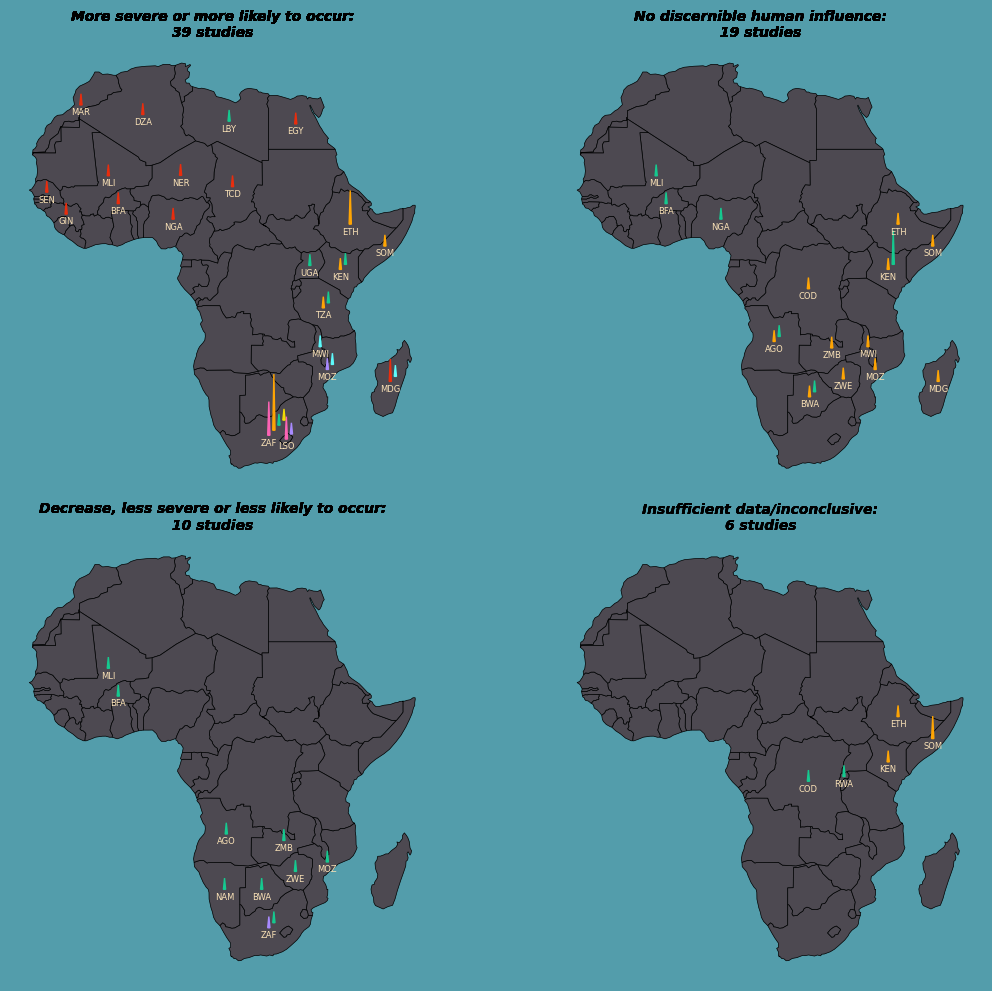

In [19]:
# Get the unique values for the 4 subplots
classifications = df["classification"].unique()

# Create a 2x2 of subplots 
fig, axes = plt.subplots(2, 2, figsize=(12, 10), facecolor="#539DAB")

# Convert Axes from a matrix to a flat list
axes = axes.flatten()

# Shift nun-unique country's spikes to avoid overlap
offset = 0.9

# Calculate centroids with offset
df["centroid_x"] = df.geometry.centroid.x + df["dup_countries"] * offset
df["centroid_y"] = df.geometry.centroid.y + df["dup_countries"] * offset

# Loop over each unique classification 
for i, classification in enumerate(classifications):
    # Select data in the current classification
    data = df[df["classification"] == classification]
    # Return sum values of each unique classification
    studies = data["count"].sum()

    # Select the subplot axis
    ax = axes[i]
    
    # Plot Africa
    world.plot(facecolor="#4D4951", ec="black", lw=0.5, ax=ax)

    # Unique iso country codes to label
    added_iso = set()  

    # Nested loop to create spikes and labels
    for i, row in data.iterrows():
        x = row["centroid_x"]
        y = row["centroid_y"]
        height = row["height"]
        event_type = row["event_type"]
        iso_code = row["iso_country_code"]

        triangle, color = create_triangle(x, y, height, base=0.2, event_type=event_type)
        ax.add_patch(triangle)

        # Offset to move iso labels slightly down from the centroids to avoid overlap
        y_offset = 1.8  

        # Add label for the first occurrence of each iso country code
        if iso_code not in added_iso:
            ax.text(
                x, y - y_offset,   
                iso_code,
                fontsize=6,
                color="#FAE2B7",
                ha="center"
            )
            added_iso.add(iso_code)

        # Subplot titles       
        ax.text(15, 42, f"{classification}:\n{studies} studies", weight="bold", style="italic", ha="center")

        # Set background color
        ax.set_facecolor("#539DAB")

        # Turn off the axis for each subplot
        ax.axis("off")

# Adjust layout 
plt.tight_layout()

# Show the plot
plt.show()

## Create and add a legend

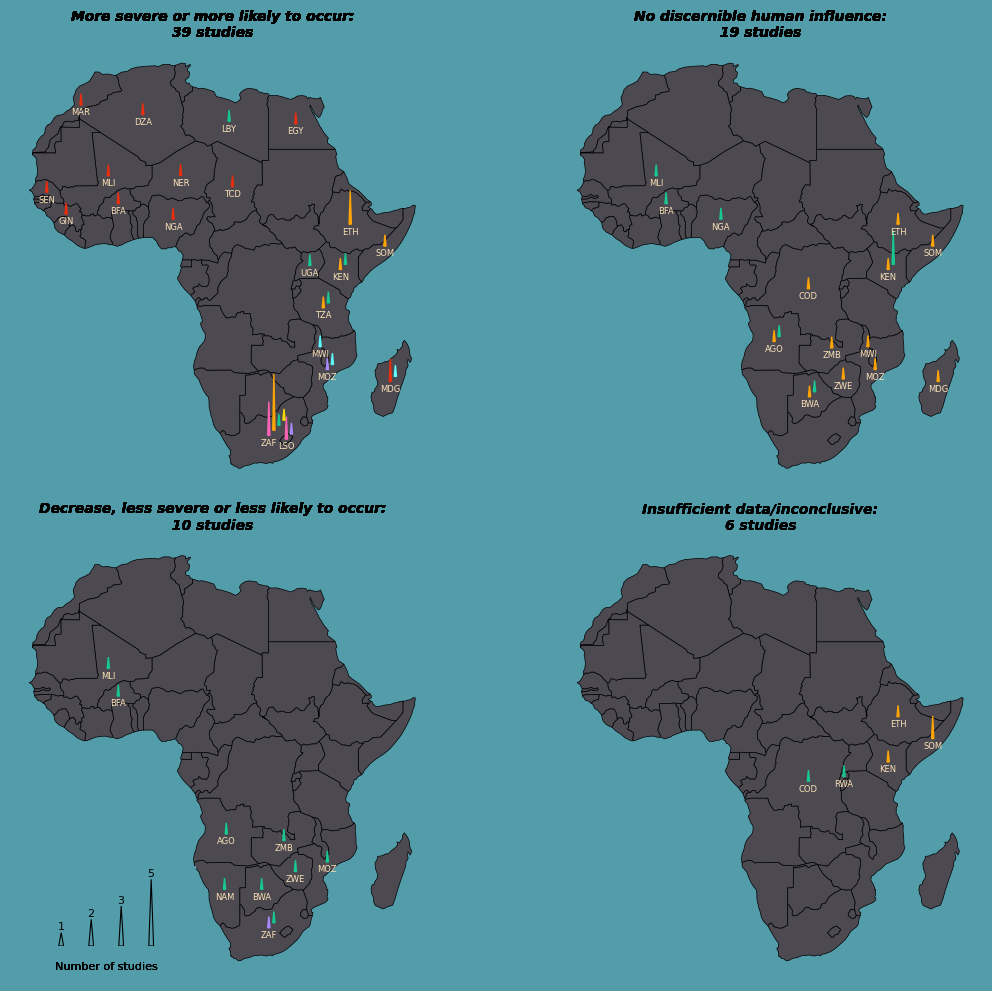

In [20]:
# Get the unique values for the 4 subplots
classifications = df["classification"].unique()

# Create a 2x2 of subplots 
fig, axes = plt.subplots(2, 2, figsize=(12, 10), facecolor="#539DAB")

# Convert Axes from a matrix to a flat list
axes = axes.flatten()

# Shift nun-unique country's spikes to avoid overlap
offset = 0.9

# Calculate centroids with offset
df["centroid_x"] = df.geometry.centroid.x + df["dup_countries"] * offset
df["centroid_y"] = df.geometry.centroid.y + df["dup_countries"] * offset

# Loop over each unique classification 
for i, classification in enumerate(classifications):
    # Select data in the current classification
    data = df[df["classification"] == classification]
    # Return sum values of each unique classification
    studies = data["count"].sum()

    # Select the subplot axis
    ax = axes[i]
    
    # Plot Africa
    world.plot(facecolor="#4D4951", ec="black", lw=0.5, ax=ax)

    # Unique iso country codes to label
    added_iso = set()  

    # Nested loop to create spikes and labels
    for i, row in data.iterrows():
        x = row["centroid_x"]
        y = row["centroid_y"]
        height = row["height"]
        event_type = row["event_type"]
        iso_code = row["iso_country_code"]

        triangle, color = create_triangle(x, y, height, base=0.2, event_type=event_type)
        ax.add_patch(triangle)

        # Offset to move iso labels slightly down from the centroids to avoid overlap
        y_offset = 1.8  

        # Add label for the first occurrence of each iso country code
        if iso_code not in added_iso:
            ax.text(
                x, y - y_offset,   
                iso_code,
                fontsize=6,
                color="#FAE2B7",
                ha="center"
            )
            added_iso.add(iso_code)

        # Subplot titles       
        ax.text(15, 42, f"{classification}:\n{studies} studies", weight="bold", style="italic", ha="center")

        # Set background color
        ax.set_facecolor("#539DAB")

        # Turn off the axis for each subplot
        ax.axis("off")

## Legend ##
# Create child ax and set axis limits
inset_ax = fig.add_axes([0.1, 0.05, 0.15, 0.08]) 
inset_ax.set_xlim(0, 0.6)
inset_ax.set_ylim(0, 12)

# Function to create triangle outlines
def create_legend(x, height, y=0, base=0.008):        
    triangle = mpatches.Polygon(
        [[x - base, y], [x, y + height], [x + base, y]],
        ec="black",   
        lw=0.8,
        fill=False    
    )
    return triangle

# Triangle params
x_vals = [0.15, 0.25, 0.35, 0.45]
height_vals = [1, 2, 3, 5]

# Loop to create and add triangles and labels
for xpos, h in zip(x_vals, height_vals):
    triangle = create_legend(xpos, h*2)
    inset_ax.add_patch(triangle)
    inset_ax.text(
        xpos,                
        h*2 + 0.1,            
        str(h),              
        ha="center",
        va="bottom",
        fontsize=8
    )
    # Remove the spines
    inset_ax.spines[["top", "right", "left", "bottom"]].set_visible(False)   
    # Remove all ticks
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])    
    # Add x label
    inset_ax.text(0.5,-0.3,"Number of studies", size=8, ha="center", transform=inset_ax.transAxes) # Use axis coordinates i/o data coordinates
    # Background color
    inset_ax.set_facecolor("#539DAB")

# Adjust layout 
plt.tight_layout()

# Show the plot
plt.show()

# Add annotations, arrow and texts

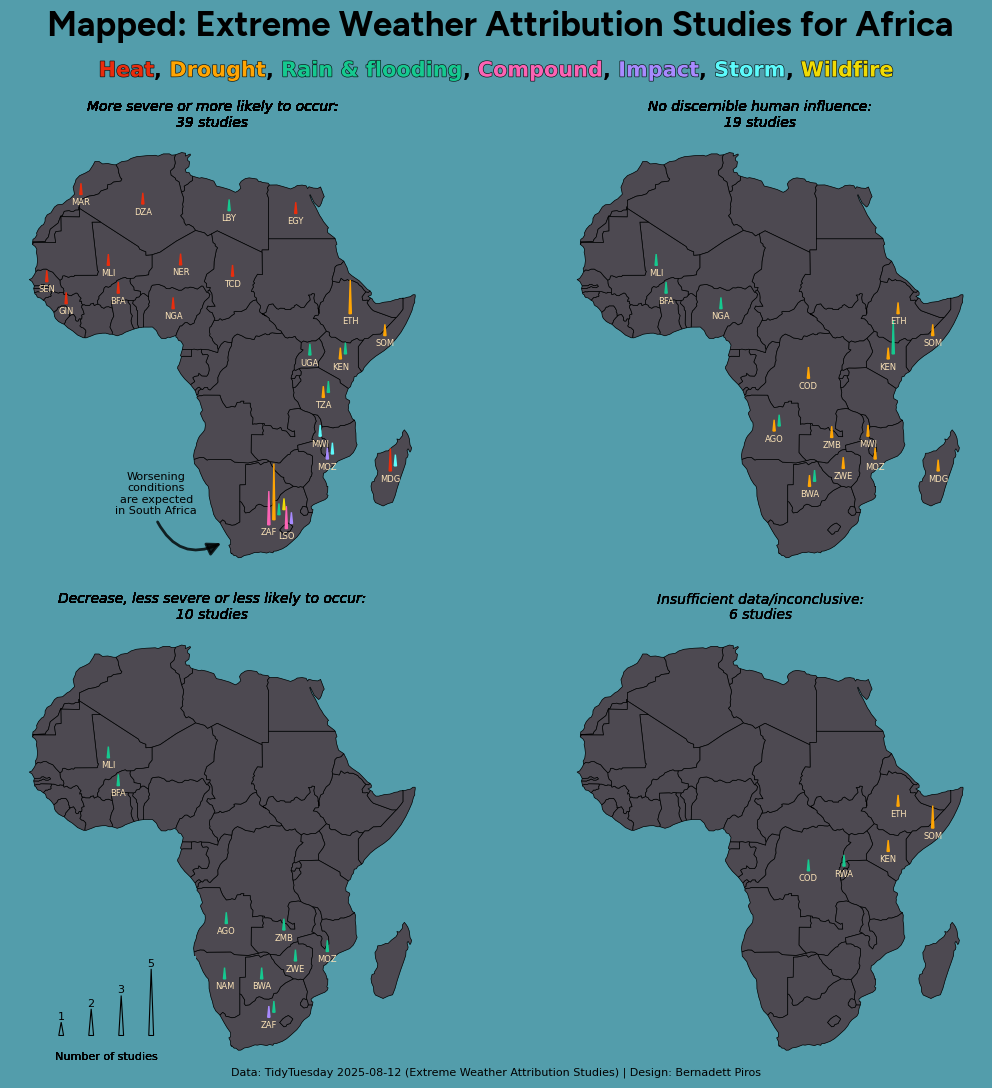

In [21]:
# Get the unique values for the 4 subplots
classifications = df["classification"].unique()

# Create a 2x2 of subplots 
fig, axes = plt.subplots(2, 2, figsize=(12, 10), facecolor="#539DAB")

# Convert Axes from a matrix to a flat list
axes = axes.flatten()

# Shift nun-unique country's spikes to avoid overlap
offset = 0.9

# Calculate centroids with offset
df["centroid_x"] = df.geometry.centroid.x + df["dup_countries"] * offset
df["centroid_y"] = df.geometry.centroid.y + df["dup_countries"] * offset

# Loop over each unique classification 
for i, classification in enumerate(classifications):
    # Select data in the current classification
    data = df[df["classification"] == classification]
    # Return sum values of each unique classification
    studies = data["count"].sum()

    # Select the subplot axis
    ax = axes[i]
    
    # Plot Africa
    world.plot(facecolor="#4D4951", ec="black", lw=0.5, ax=ax)

    # Unique iso country codes to label
    added_iso = set()  

    # Nested loop to create spikes and labels
    for i, row in data.iterrows():
        x = row["centroid_x"]
        y = row["centroid_y"]
        height = row["height"]
        event_type = row["event_type"]
        iso_code = row["iso_country_code"]

        triangle, color = create_triangle(x, y, height, base=0.2, event_type=event_type)
        ax.add_patch(triangle)

        # Offset to move iso labels slightly down from the centroids to avoid overlap
        y_offset = 1.8  

        # Add label for the first occurrence of each iso country code
        if iso_code not in added_iso:
            ax.text(
                x, y - y_offset,   
                iso_code,
                fontsize=6,
                color="#FAE2B7",
                ha="center"
            )
            added_iso.add(iso_code)

        # Subplot titles       
        ax.text(15, 42, f"{classification}:\n{studies} studies", style="oblique", ha="center")

        # Set background color
        ax.set_facecolor("#539DAB")

        # Turn off the axis for each subplot
        ax.axis("off")

## Legend ##
# Create child ax and set axis limits
inset_ax = fig.add_axes([0.1, 0.05, 0.15, 0.08]) 
inset_ax.set_xlim(0, 0.6)
inset_ax.set_ylim(0, 12)

# Function to create triangle outlines
def create_legend(x, height, y=0, base=0.008):        
    triangle = mpatches.Polygon(
        [[x - base, y], [x, y + height], [x + base, y]],
        ec="black",   
        lw=0.8,
        fill=False    
    )
    return triangle

# Triangle params
x_vals = [0.15, 0.25, 0.35, 0.45]
height_vals = [1, 2, 3, 5]

# Loop to create and add triangles and labels
for xpos, h in zip(x_vals, height_vals):
    triangle = create_legend(xpos, h*2)
    inset_ax.add_patch(triangle)
    inset_ax.text(
        xpos,                
        h*2 + 0.1,            
        str(h),              
        ha="center",
        va="bottom",
        fontsize=8
    )
    # Remove the spines
    inset_ax.spines[["top", "right", "left", "bottom"]].set_visible(False)   
    # Remove all ticks
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])    
    # Add x label
    inset_ax.text(0.5,-0.3,"Number of studies", size=8, ha="center", transform=inset_ax.transAxes) # Use axis coordinates i/o data coordinates
    # Background color
    inset_ax.set_facecolor("#539DAB")

## Arrow and abbotations##
# Arrows and annotations
ax_arrow(
  tail_position=[5, -28],
  head_position=[17, -32],
  color="black",
  width=2,
  radius=0.5,
  alpha=0.8,
  ax=axes[0],
)
axes[0].text(5, -27, "Worsening\nconditions\nare expected\nin South Africa", size=8, ha="center")

## Texts##
# Title
fig.text(0.5, 1.05, " Mapped: Extreme Weather Attribution Studies for Africa", font=figtree_bold, size=25, ha="center")
# Caption
fig.text(0.5, 0.01, "Data: TidyTuesday 2025-08-12 (Extreme Weather Attribution Studies) | Design: Bernadett Piros", size=8, ha="center")

# Path effect for subtitle
def define_path_effect(**kwargs):
    return [path_effects.Stroke(**kwargs), path_effects.Normal()]

my_path_effect = define_path_effect(
    linewidth=1,
    foreground="black",
    alpha=0.8
)
    
# Subtitle
fig_text(0.5, 1.025, s="<Heat>, <Drought>, <Rain & flooding>, <Compound>, <Impact>, <Storm>, <Wildfire>", size=15, weight="bold", ha="center", 
        highlight_textprops=[
            {"color": color_dict["Heat"], "path_effects": my_path_effect},
            {"color": color_dict["Drought"], "path_effects": my_path_effect},
            {"color": color_dict["Rain & flooding"], "path_effects": my_path_effect},
            {"color": color_dict["Compound"], "path_effects": my_path_effect},
            {"color": color_dict["Impact"], "path_effects": my_path_effect},
            {"color": color_dict["Storm"], "path_effects": my_path_effect},
            {"color": color_dict["Wildfire"], "path_effects": my_path_effect},            
            ])

# Adjust layout 
plt.tight_layout()

# Show the plot
plt.show()

fig.savefig("2025-08-12.png", bbox_inches='tight', pad_inches=0.2)